In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import statsmodels.api as sm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/Users/gbromley/code/python_utilities/')
from python_data_functions import extract_months
from python_met_functions import sat_vap_pres
from python_data_functions import mk_test
import metpy.calc as mcalc
from metpy.units import units
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText



In [3]:
data_dir = '/Users/gbromley/data/CRU/'
output_dir='/Users/gbromley/code/NGP_Climate/'
temp_file = 'tmx/cru_ts4.01.1901.2016.tmx.dat.nc'
nc_temp = xr.open_dataset(data_dir+temp_file)

In [21]:
t2m = nc_temp['tmx']

t2m = t2m.sel(lat=slice(38,55),lon=slice(-120,-92))

t_season='AMJ'
t_months=[4,5,6]
start_year = '1970-01-01'
end_year = '2015-12-01'
ext_e = -92
ext_w = -120
ext_n = 55
ext_s = 38

<xarray.DataArray 'tmx' ()>
array(11.758410424324147)

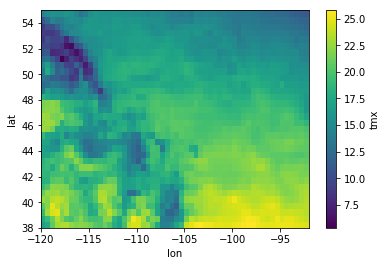

In [25]:
t2m_clim_months_avg.plot()

In [24]:
#extract the time period we are interested in
t2m_slice=t2m.sel(time=slice(start_year,end_year))
#grab the months interested in
t2m_months = t2m_slice.sel(time=extract_months(t2m_slice['time.month'],t_months[0],t_months[-1]))
#create month averages
t2m_months_avg = t2m_months.groupby('time.year').mean(dim='time')

#extract the 30 yr climate normal times
t2m_clim_30= t2m.sel(time=slice('1980-01-01','2011-01-01'))
#grab the months
t2m_clim_months_30 = t2m_clim_30.sel(time=extract_months(t2m_clim_30['time.month'],t_months[0],t_months[-1]))
#create averages over months for climate normal
t2m_clim_months_avg = t2m_clim_months_30.mean(dim='time')

In [7]:
#create 2d structure to hold slope
spatial_trend = t2m.isel(time=1).copy(deep=True)
spatial_trend.name = 't2m_trend'
spatial_trend.attrs['units'] = 'C per Decade'
spatial_trend.attrs['long_name'] = '2 meter temperature trend'

#create 2d structure to hold pvalues
pvalues= t2m.isel(time=1).copy(deep=True)
pvalues.name = 't2m_trend_pvalues'
pvalues.attrs['units'] = 'pvalues'
pvalues.attrs['long_name'] = '2 meter temperature trend pvalues'

In [8]:
#calculate slope and pvalue for each grid point
#replace with a map() call?
for i in np.arange(0,len(t2m['lat'])):
    for j in np.arange(0,len(t2m['lon'])):
        series = t2m_months_avg[:,i,j]
        anom = series-t2m_clim_months_avg[i,j]
        model = sm.OLS(np.arange(0,len(anom)),np.asarray(anom.values))
        results = model.fit()
        slope = results.params[0]
        #t_value = ((slope - (0.2/10))/results.bse)
        #p_value = stats.t.sf(t_value, results.df_resid)
       # p_value = stats.t.sf(results.tvalues[0], results.df_resid)
        spatial_trend[i,j]=slope
        #pvalues[i,j]= p_value

/Users/gbromley/anaconda/lib/python3.5/site-packages/numpy/linalg/linalg.py:1591: RuntimeWarning: invalid value encountered in greater
  return sum(S > tol)


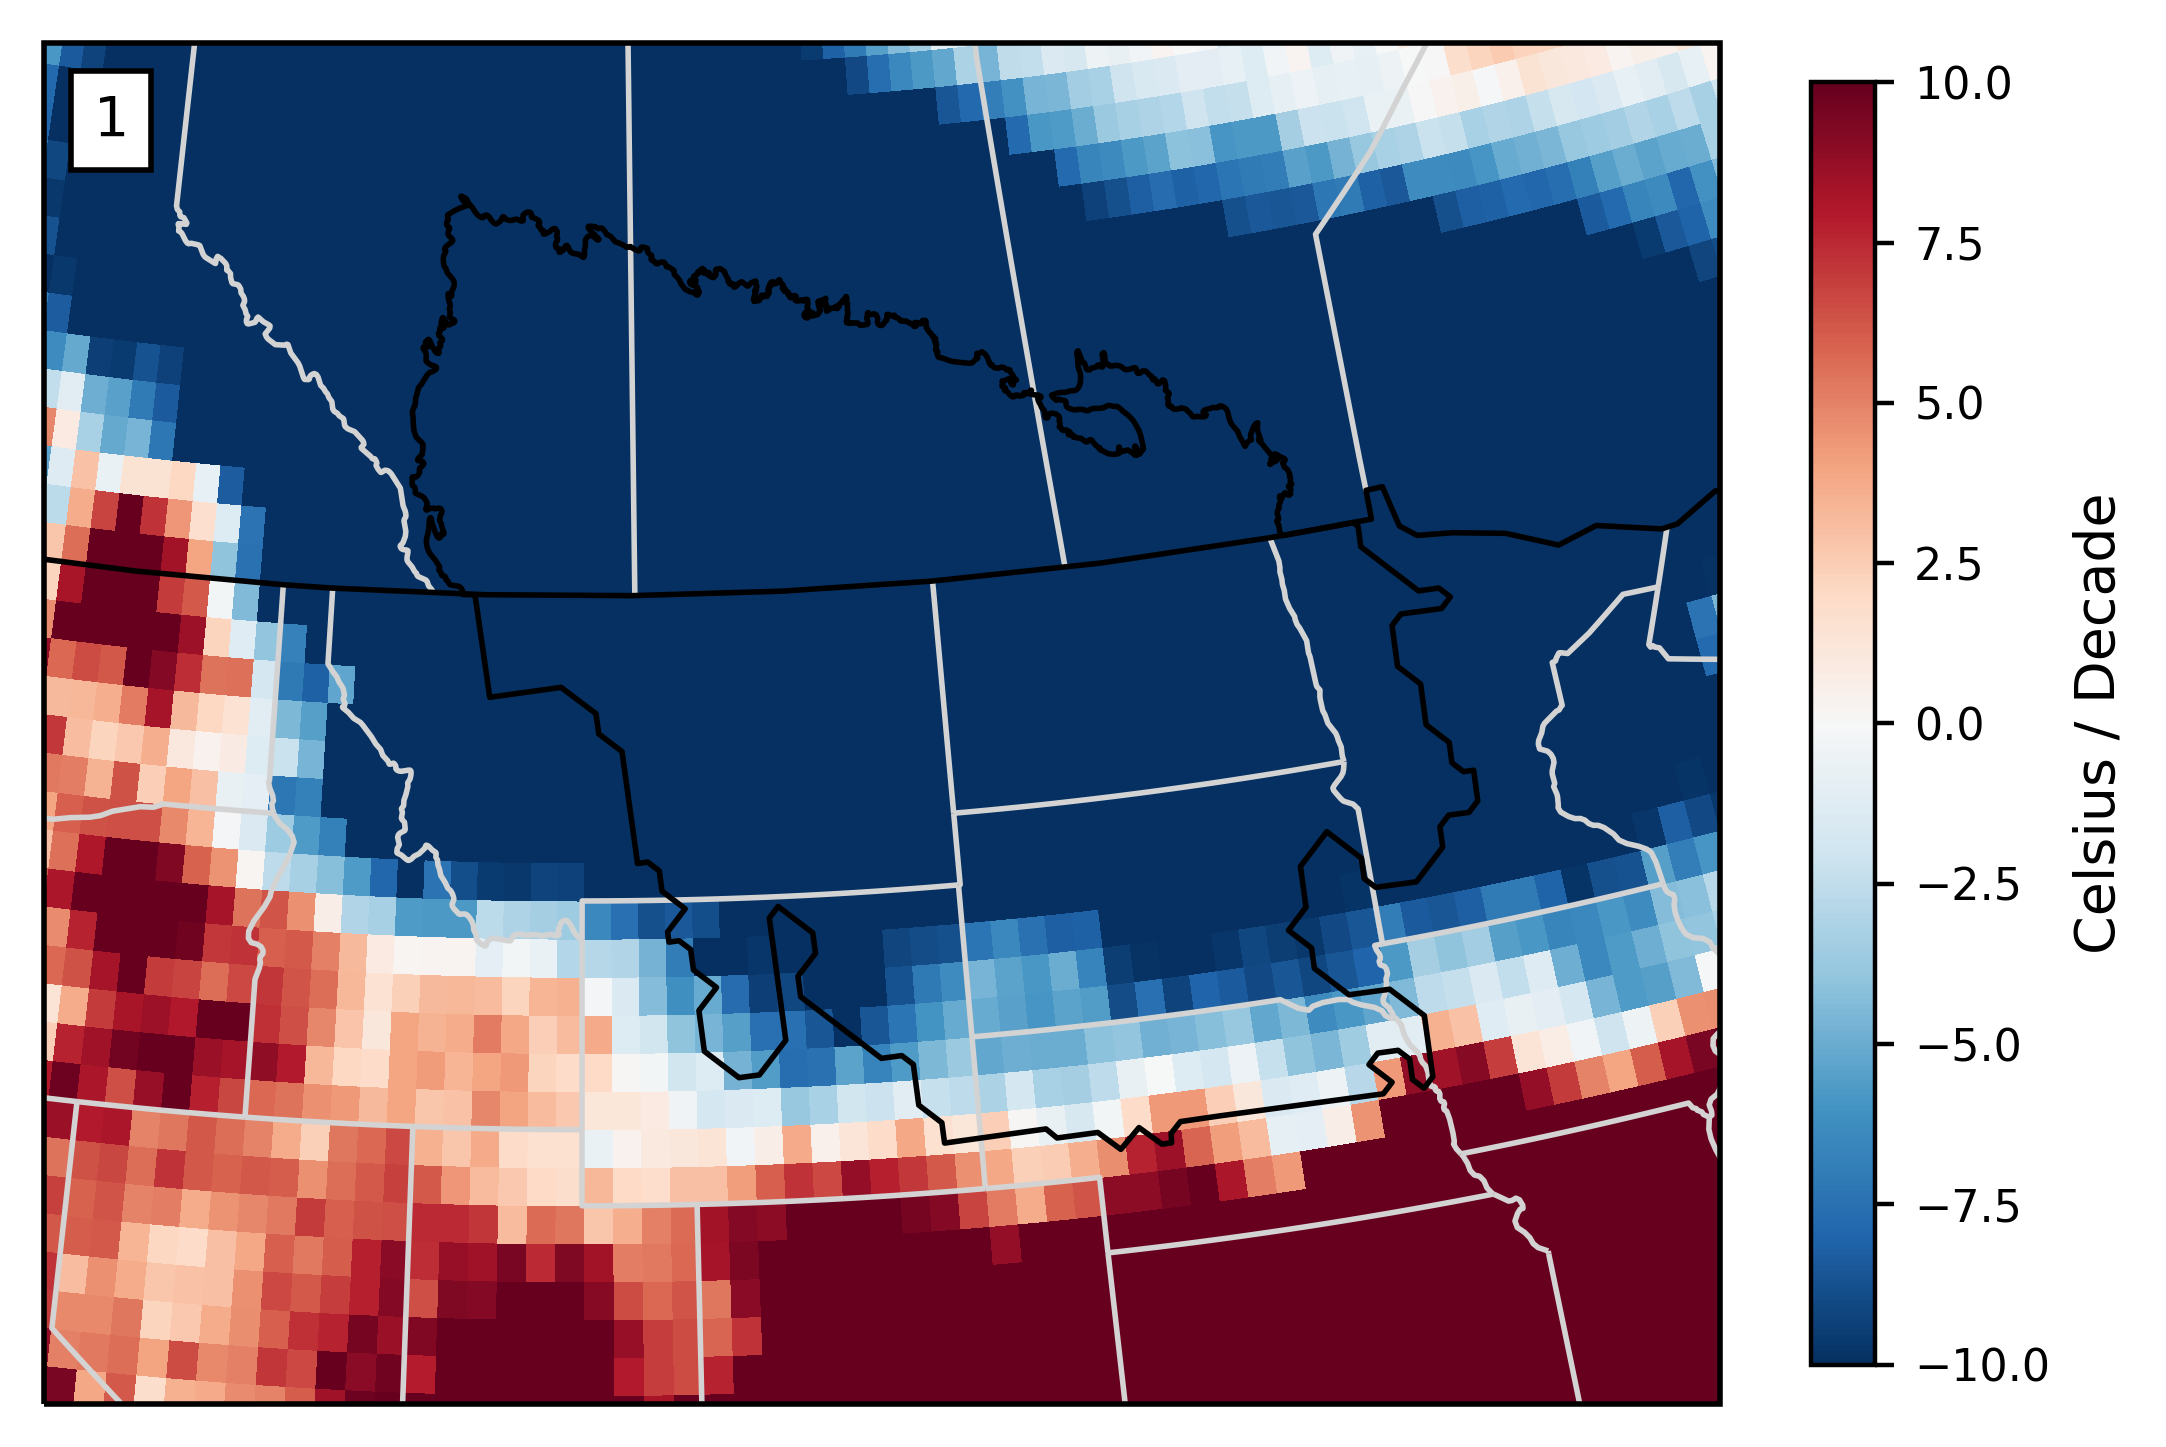

In [10]:
fig = plt.figure(1,figsize=(13,7), dpi=400.0)
projection = ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None)
ax1 = plt.subplot(1,2,1, projection = projection)
#ax1 = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax1.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax1, transform=ccrs.PlateCarree(),vmin=-10, vmax=10, cmap='RdBu_r',add_colorbar = False)
#ax = plt.axes(projection=ccrs.LambertConformal())

ax1.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax1.add_feature(states_provinces, edgecolor='lightgray')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
shape_feature = ShapelyFeature(Reader('/Users/gbromley/Dropbox/Montana_Climate_Project/Study_Area/Study_Area_08_01_17.shp').geometries(),crs=ccrs.PlateCarree(), facecolor='none',edgecolor='black')
ax1.add_feature(shape_feature)
#plt.plot(ggw_lon, ggw_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.plot(ftp_lon, ftp_lat, axes = ax1, marker='o', markersize = 8, color='black', transform=ccrs.PlateCarree())
#plt.text(ftp_lon+0.5, ftp_lat, 'US-FPe', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
#plt.text(ggw_lon-2, ggw_lat, 'GGW', axes=ax1, color='black', size=8, transform=ccrs.PlateCarree())
ax1.title.set_visible(False)
cb = plt.colorbar(test, cmap='RdBu_r',fraction=0.035)
cb.set_label('Celsius / Decade',fontsize=10)
cb.ax.tick_params(labelsize=8)
#plt.text(0, 1,'a', ha='center', va='center', backgroundcolor='lightgray')
#anchored_text = AnchoredText("1", loc=2)
#ax1.add_artist(anchored_text)

#plt.savefig('CRU_max_temp_'+t_season+'_1970.png',bbox_inches='tight')
plt.show()

In [27]:
anom_series = t2m_months_avg - t2m_clim_months_avg
test_series = anom_series.sel(lat=48.75)
test_series = test_series.sel(lon=-106.75)
anom_series = test_series
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(anom_series)),anom_series.values)
line = slope*np.arange(0,len(anom_series.values))+intercept
anom_series = anom_series.to_pandas()

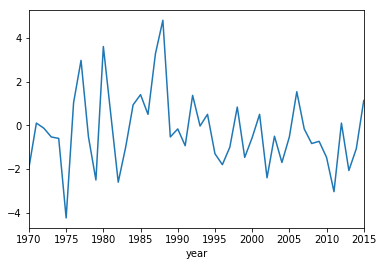

In [28]:
anom_series.plot()